In [16]:
import sys

import graphviz
import numpy as np
import pandas as pd
# hack omwille van bug in Id3Estimator
import six
from id3.export import DotTree

sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_graphviz

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Scores voor vakken voorspellen

We geven een lijst van studenten aan een docent en vragen hoe hij/zij deze studenten inschat.
De docent mag aan iedere student een score toekennen volgens zijn gevoel (niet volgens punten).
We verwachten dat een docent dit onbewust toch zal doen op basis van zijn eigen vakken.


1. Lees het bestand "studentenScores.csv" in.  Hierin zie je de subjectieve scores, gegeven door de docent.  De score kan zijn: "goed", "gemiddeld", "slecht".  We vragen ons nu af op basis van welke criteria de docent zijn scores heeft gegeven.

In [21]:
grades = pd.read_csv("data/studentenScores.csv")
grades.score = grades.score.astype(pd.CategoricalDtype(categories=['slecht', 'gemiddeld', 'goed'], ordered=True))

grades.info()
grades.head()
display(grades)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   vak1    100 non-null    int64   
 1   vak2    100 non-null    int64   
 2   vak3    100 non-null    int64   
 3   vak4    100 non-null    int64   
 4   vak5    100 non-null    int64   
 5   vak6    100 non-null    int64   
 6   vak7    100 non-null    int64   
 7   vak8    100 non-null    int64   
 8   vak9    100 non-null    int64   
 9   score   100 non-null    category
dtypes: category(1), int64(9)
memory usage: 7.4 KB


,vak1,vak2,vak3,vak4,vak5,vak6,vak7,vak8,vak9,score
0,13,9,17,2,17,1,0,14,18,gemiddeld
1,10,13,5,20,20,14,4,2,10,goed
2,13,4,2,19,3,9,16,13,7,goed
3,8,3,17,7,16,10,15,9,8,slecht
4,1,12,13,2,9,10,2,2,13,slecht
...,...,...,...,...,...,...,...,...,...,...
95,14,10,15,4,4,6,10,13,8,gemiddeld
96,16,10,16,1,8,11,19,0,13,gemiddeld
97,0,20,9,7,13,11,18,10,9,slecht
98,14,15,16,9,4,8,10,18,9,gemiddeld


2. Stel daartoe een beslissingsboom op voor de score.

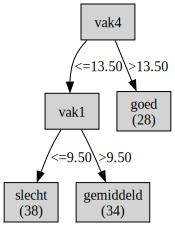

In [22]:
%%capture --no-display

model = Id3Estimator()

X = grades.drop(['score'], axis=1).to_numpy().tolist()
y = grades['score'].to_numpy().tolist()
model.fit(X, y)

model_tree = DotTree()
_ = export_graphviz(model.tree_, model_tree, feature_names=grades.drop(columns=['score']).columns)
graphviz.Source(model_tree.dot_tree)

3. Welke vakken geeft de docent?

In [25]:
grades['scores_likert'] = grades.score.cat.codes
grades.corr()['scores_likert'].sort_values(ascending=False)
# de scores op likert schaal correleren het meest met vakken 4 en 1.
grades.drop('scores_likert', axis=1, inplace=True)

ValueError: could not convert string to float: 'gemiddeld'

In [29]:
# alternatieve oplossing
#Laten we eerst een andere maat voor 'score' gebruiken - vb. het gemiddelde
grades['avg'] = grades.drop('score', axis=1).mean(axis=1)
#Als we sorteren op het gemiddelde over alle vakken dan zien we dat er amper correlatie is tussen SCORE en AVG, hetgeen enige 'subjectiviteit' aantoont.
grades.sort_values(by=['avg'], ascending=False)

# Uit de boomstructuur zien we dat studenten die hoog (> 13.50) scoren op Vak 4
# door de docent als "GOED" beoordeeld onafhankelijk van zijn andere vakken.

#Als we nu alle data sorteren op Vak4
grades.sort_values(by=['vak4'], ascending=False)
#Dan zien we ineens WEL een sterke correlatie tussen die sortering en de score (ie. hoog op Vak4 => score=goed)

#gooi de tijdelijke kolom terug weg
grades = grades.drop('avg', axis=1)
print(grades)

    vak1  vak2  vak3  vak4  vak5  vak6  vak7  vak8  vak9      score   
0     13     9    17     2    17     1     0    14    18  gemiddeld  \
1     10    13     5    20    20    14     4     2    10       goed   
2     13     4     2    19     3     9    16    13     7       goed   
3      8     3    17     7    16    10    15     9     8     slecht   
4      1    12    13     2     9    10     2     2    13     slecht   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...        ...   
95    14    10    15     4     4     6    10    13     8  gemiddeld   
96    16    10    16     1     8    11    19     0    13  gemiddeld   
97     0    20     9     7    13    11    18    10     9     slecht   
98    14    15    16     9     4     8    10    18     9  gemiddeld   
99    14    20     6     2    12     4     7    14     3  gemiddeld   

    scores_likert  
0               1  
1               2  
2               2  
3               0  
4               0  
..            ...  
95     

4. De boomstructuur is nogal complex.

Dat komt omdat de punten veel waarden kunnen aannemen.
We kunnen dit oplossen door de punten op te delen in categorieën:
 * niet geslaagd (0-9),
 * voldoening (10-13),
 * onderscheiding (14-15),
 * grote onderscheiding (16-20).

Probeer de scores zo in te delen.


In [33]:
grades_cat = grades.drop('score', axis=1).apply(pd.cut, bins=[0, 10, 14, 16, 21], right=False, labels=['niet geslaagd', 'voldoening', 'onderscheiding', 'grote onderscheiding'])
grades_cat['score'] = grades.score

5. Bereken nu de boomstructuur opnieuw.  Is dit duidelijker?

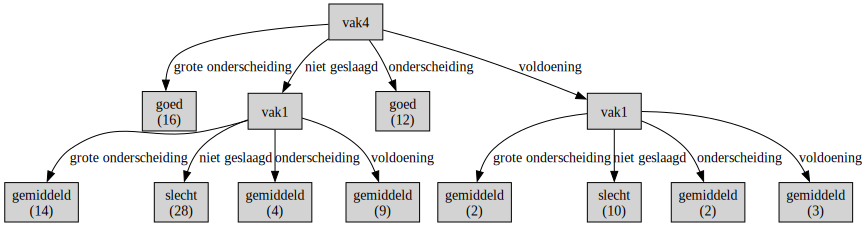

In [32]:
%%capture --no-display

model = Id3Estimator()
X = grades_cat.drop(['score'], axis=1).values.tolist()
y = grades_cat['score'].values.tolist()
model.fit(X, y)

model_tree = DotTree()
_ = export_graphviz(model.tree_, model_tree, feature_names=grades_cat.drop(columns=['score']).columns)
graph = graphviz.Source(model_tree.dot_tree)
graph

6. Hoe zou de docent iemand inschatten als die volgende punten heeft: 9, 14, 13, 12, 15, 13, 7, 10, 18

In [34]:
%%capture --no-display
scores = pd.cut([9, 14, 13, 12, 15, 13, 7, 10, 18], bins=[0, 10, 14, 16, 21],
                right=False, labels=['niet geslaagd', 'voldoening', 'onderscheiding', 'grote onderscheiding']).tolist()
model.predict([scores])
## => SLECHT

ValueError: Number of features of the model must match the input. Model n_features is 10 and input n_features is 9.

7. Maak eens een boomstructuur met het C4.5 algoritme en een ScitKit DecisionTree op de originele gegevens en kijk welk resultaat daar uit komt.

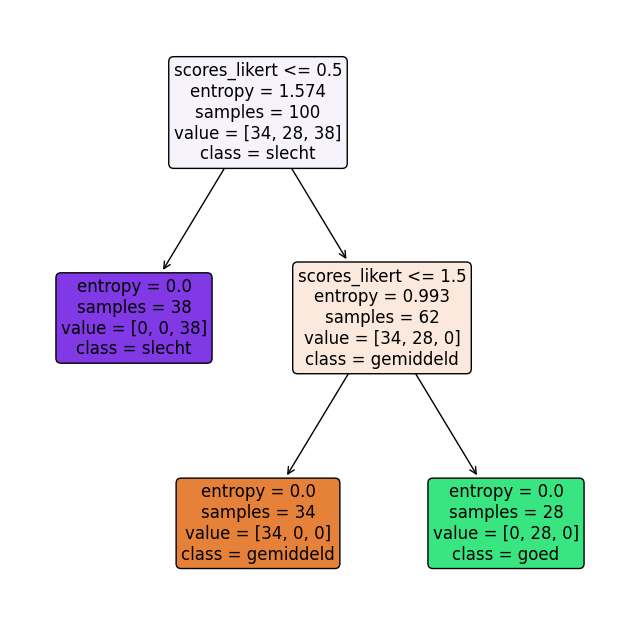

In [35]:
classifier = DecisionTreeClassifier(criterion='entropy')
X = grades.drop(columns=['score'])
y = grades.score
classifier.fit(X, y)

#print(export_text(classifier, feature_names=X.columns))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
_ = tree.plot_tree(classifier, ax=ax, feature_names=X.columns.values, class_names=['{}'.format(i) for i in np.unique(y)], filled=True, fontsize=12, rounded=True)

8. Maak eens een boomstructuur met een ScitKit DecisionTree op de onehot encoded gegevens (gebruik Pandas `get_dummies`) en kijk welk resultaat daar uit komt.

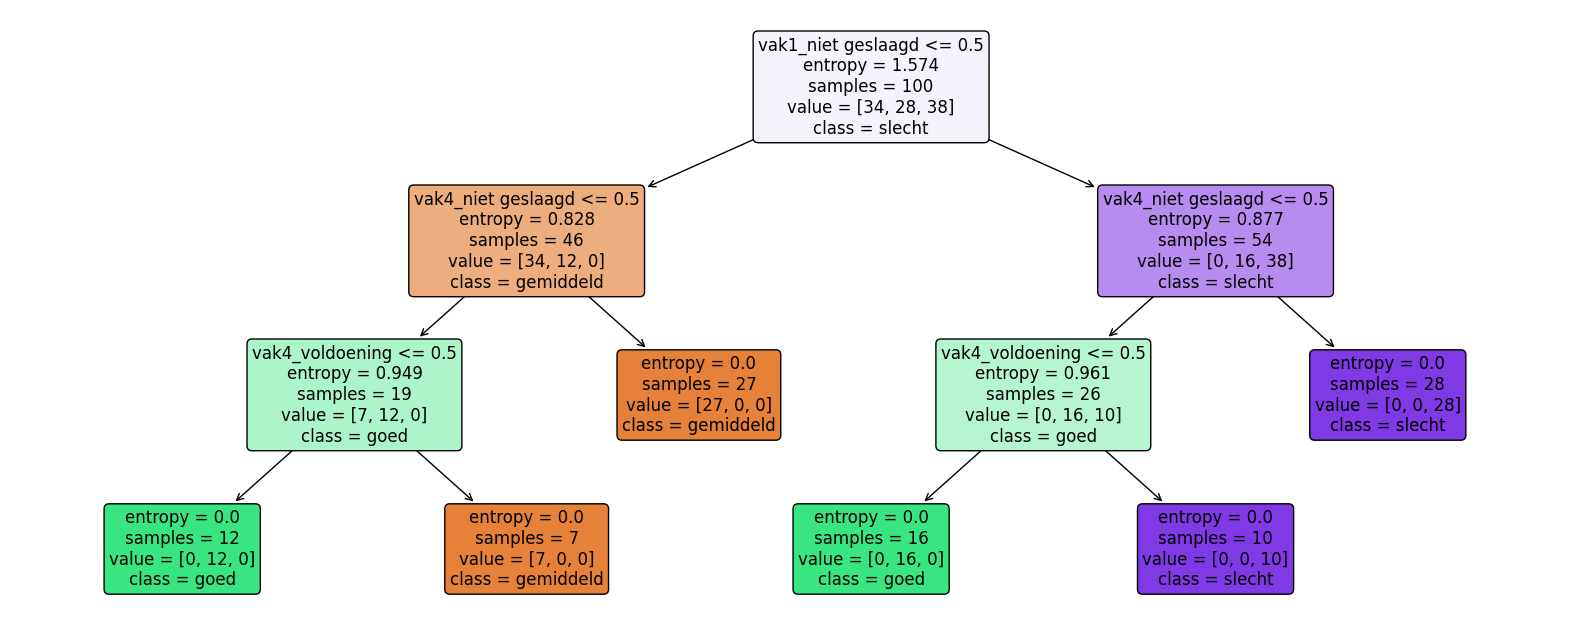

In [36]:
X = pd.get_dummies(grades_cat.drop(columns=['score']))
y = grades_cat.score
classifier.fit(X, y)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 8))
_ = tree.plot_tree(classifier,
                   ax=ax,
                   feature_names=X.columns.values,
                   class_names=['{}'.format(i) for i in np.unique(y)],
                   filled=True, fontsize=12, rounded=True)
